In [1]:
%load_ext autoreload
%autoreload 2
import finoptions as fo

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
S = 100
K = 100
t = 1 / 12
sigma = 0.4
r = 0.10
b = 0.1

path_length = 30
mc_paths = 5000
mc_loops = 50

## Full Example from Scratch

In [5]:
import finoptions as fo
from scipy.stats import qmc, norm
import numpy as np
from finoptions.monte_carlo_options import Innovations, Path, Payoff
S = 100
K = 100
t = 1 / 12
sigma = 0.4
r = 0.10
b = 0.1
path_length = 30
mc_paths = 5000
mc_loops = 50

class NormalSobolInnovations(Innovations):
    def sample_innovation(self, scramble=True):
        sobol = qmc.Sobol(self.path_length, scramble=scramble).random(self.mc_paths)
        if scramble == False:
            # add new sample since if not scrambled first row is zero which leads to -inf when normalized
            sobol = sobol[1:]
            sobol = np.append(
                sobol,
                qmc.Sobol(self.path_length, scramble=scramble).fast_forward(self.mc_paths).random(1),
                axis=0,
            )
        sobol = norm.ppf(sobol)
        return sobol

class WienerPath(Path):
    def generate_path(self, **kwargs):
        return (self.b - (self.sigma ** 2) / 2) * self.dt + self.sigma * np.sqrt(self.dt)  * self.epsilon

class PlainVanillaPayoff(Payoff):
    def call(self):
        St = self.S * np.exp(np.sum(self.path.generate_path(), axis=1))
        return np.exp(-self.r * self.t) * np.maximum(St - self.K, 0)

    def put(self):
        St = self.S * np.exp(np.sum(self.path.generate_path(), axis=1))
        return np.exp(-self.r * self.t) * np.maximum(self.K - St, 0)

mc = fo.monte_carlo_options.MonteCarloOption(
        mc_loops, path_length, mc_paths,
        S, K, t, r, b, sigma,
        NormalSobolInnovations, WienerPath, PlainVanillaPayoff,
        trace=False, antithetic=True, standardization=False
    )


In [6]:
mc.call().mean()


/home/bcho/miniconda3/envs/main/lib/python3.9/site-packages/scipy/stats/_qmc.py:1078: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


5.006205483595199

In [9]:
y = mc.call()

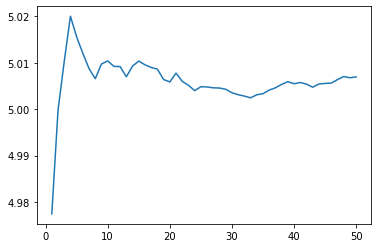

In [10]:
plt.plot(np.arange(y.size)+1, y.cumsum()/(np.arange(y.size)+1))

In [11]:
mc.put().mean()

/home/bcho/miniconda3/envs/main/lib/python3.9/site-packages/scipy/stats/_qmc.py:1078: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


4.1833514798494384

## Simplified Example Using Prebuilt Classes

In [12]:
opt = fo.GBSOption(S, K, t, r, b, sigma)

In [13]:
inno = fo.monte_carlo_options.NormalSobolInnovations
path = fo.monte_carlo_options.WienerPath
payoff = fo.monte_carlo_options.PlainVanillaPayoff

In [14]:
mc = fo.monte_carlo_options.MonteCarloOption(
    mc_loops, path_length, mc_paths, 
    S, K, t, r, b, sigma,
    inno, path, payoff,
    trace=False, antithetic=True, standardization=False
)


In [15]:

print("MC: ", mc.call().mean(), "GBS: ", opt.call())



MC:  5.008760972257951 GBS:  5.011784286195763


In [16]:

print("MC: ", mc.put().mean(), "GBS: ", opt.put())



MC:  4.1788687614474584 GBS:  4.181913550083365
